# El Camino hacia el Óptimo: Construyendo el Algoritmo

La base de nuestro desarrollo comienza con importar las librerías necesarias y definir nuestro modelo computacionalmente:

## Inclusión de módulos necesarios

Estas importaciones nos preparan el entorno para trabajar con funciones matemáticas y visualizaciones.  
Permiten usar **tipado avanzado**, realizar **cálculos numéricos con `NumPy`**, y generar **gráficos personalizados** con `Matplotlib`.


In [2]:
from __future__ import annotations  # Mejora las anotaciones de tipo.
import numpy as np  # Operaciones numéricas con arrays.
from typing import Callable, Optional  # Tipos para funciones y valores opcionales.
import matplotlib.pyplot as plt  # Gráficos y visualizaciones.
import matplotlib.colors as mcolors  # Manejo de colores en gráficos.

In [43]:
!pip install numpy matplotlib

## Procedemos a definir nuestra función objetivo.

Estas líneas definen una función cuadrática de dos variables, expresada tanto en su forma explícita como en su forma matricial.  
El objetivo es representar matemáticamente una superficie parabólica sobre la cual se aplicarán métodos de optimización numérica.  

Primero se construyen los componentes de la forma cuadrática general  
\( f(x) = \frac{1}{2}x^T Q x + c^T x + r \),  
donde:
- `Q` es la **matriz simétrica** que determina la curvatura de la superficie (la forma del valle o colina).  
- `c` es el **vector de coeficientes lineales** que desplaza el mínimo de la función.  
- `r` es una **constante escalar** que ajusta el valor base de la función.  
- `x0` define el **punto inicial** desde el cual comenzará el proceso iterativo de optimización.  

Finalmente, se define `f` como una **función escalar equivalente**, útil para generar representaciones gráficas en dos dimensiones (superficies o curvas de nivel) del mismo modelo matemático.

In [3]:
# f(x, y) = (x + y - 7)^2 + (2x + y - 5)^2
# En forma cuadrática: f(x) = 1/2 x^T Q x + c^T x + r
Q = np.array([[10.0, 6.0],
              [ 6.0, 4.0]])
c = np.array([-34.0, -24.0])
r = 74.0
x0 = np.array([0.0, 0.0])  # punto inicial (0,0)

# Función escalar para graficación
f = lambda X, Y: (X + Y - 7.0)**2 + (2.0 * X + Y - 5.0)**2

## Método de Máximo Descenso
Bien... el algoritmo es bastante sencillo e intuitivo, si bien está en Python  
se entiende casi como si fuera pseudocódigo:

### Implementación en Python del Algoritmo de Máximo Descenso Óptimo:

In [4]:
def maximo_descenso_optimo(Q, c, x0, tol=1e-8, max_iter=1000, verbose=False):
    """
    Máximo descenso para f(x) = 1/2 x^T Q x + c^T x + r
    usando el paso analítico óptimo alpha_k = (g^T g) / (g^T Q g).
    NOTA: La expresión alpha_k fue previamente hallada de forma analítica (en el LaTeX).

    Parámetros:
        Q : ndarray (n,n)  -- matriz simétrica
        c : ndarray (n,)   -- vector
        x0: ndarray (n,)   -- punto inicial
        tol: float         -- tolerancia para ||gradiente||
        max_iter: int      -- número máximo de iteraciones
        verbose: bool      -- imprimir o no el progreso

    Retorna:
        x : ndarray (n,)   -- punto mínimo (x1, ..., xn) en nuestro modelo x = (x1, x2)
        info : dict        -- historial (opcional)
    """
    # --- Validaciones simples ---
    Q = np.array(Q, dtype=float)
    c = np.array(c, dtype=float)
    x = np.array(x0, dtype=float)

    # --- Dimensiones ---
    n = x.shape[0]
    assert Q.shape == (n, n)
    assert c.shape == (n,)

    # --- Comprobar simetría numérica ---
    if not np.allclose(Q, Q.T, atol=1e-12):
        Q = 0.5 * (Q + Q.T)

    # Historial para análisis
    iters = []
    fvals = []
    alphas = []
    norms = []
    xs = []  # almacenará el vector x de cada iteración (incluye inicio y fin)

    # Guardar x inicial
    xs.append(x.copy())

    # --- Función objetivo ---
    def f_val(x_vec):
        return 0.5 * x_vec @ (Q @ x_vec) + c @ x_vec

    # --- Iteraciones ---
    for k in range(1, max_iter + 1):
        g = Q @ x + c                      # gradiente g_k = Q x_k + c
        gn = np.linalg.norm(g)             # ||g_k||

        iters.append(k)
        fvals.append(f_val(x))
        norms.append(gn)

        if verbose:
            print(f"Iter {k:3d}: ||g|| = {gn:.3e}, f = {fvals[-1]:.6e}")

        # Criterio de parada
        if gn < tol:
            if verbose:
                print("Criterio de parada alcanzado (||g|| < tol).")
            # Guardar x final antes de salir (si se cumple criterio de parada antes de actualizar)
            xs.append(x.copy())
            break

        Qg = Q @ g                         # producto Q g_k (reutilizable)
        denom = g @ Qg                     # g^T Q g

        # Seguridad numérica: evitar división por cero / denominador no positivo
        if denom <= 0:
            raise ValueError(
                "Denominador g^T Q g ≤ 0. Q puede no ser definida positiva o g≈0."
            )

        alpha = (g @ g) / denom            # alpha_k óptimo
        alphas.append(alpha)

        # Actualización
        x = x - alpha * g
        xs.append(x.copy())

    # Guardar x después de la actualización
    xs.append(x.copy())

    info = {
        "iters": np.array(iters),
        "fvals": np.array(fvals),
        "alphas": np.array(alphas),
        "norms": np.array(norms),
    }
    # Añadir trayectorias de x (cada fila corresponde a una iteración, incluyendo inicial y final)
    info["xs"] = np.vstack(xs)

    # Redondear cada elemento de x (evitar errores numéricos)
    x = np.round(x, decimals=2)

    return x, info

### Parámetros y flujo del algoritmo de Máximo Descenso Óptimo


El enfoque de esta implementación se fundamenta en la expresión cuadrática de nuestro modelo y toma como entrada los siguientes parámetros:


- `Q`: Matriz cuadrada y simétrica que representa los coeficientes de la función cuadrática.
- `c`: Vector que acompaña a la matriz `Q` en la función objetivo. Junto con `Q`, define la forma de la función a minimizar.
- `x0`: Punto inicial desde donde comienza el algoritmo; es la primera estimación de la solución.
- `tol`: Tolerancia que determina cuándo detener el algoritmo. Si la norma del gradiente es menor que este valor, se asume que se alcanzó una solución suficientemente buena.
- `max_iter`: Número máximo de iteraciones permitidas, para evitar que el algoritmo se ejecute indefinidamente si no converge.
- `verbose`: Si es `True`, imprime información del progreso en cada iteración. Útil para depuración, seguimiento y futuras comparaciones con otros algoritmos.


#### Validación y verificación de datos (líneas 19–31)


- Líneas 19–22: Convierte las entradas `Q`, `c` y `x0` a arreglos de NumPy de tipo `float`. Esto garantiza un formato numérico uniforme y evita errores de tipo, truncamiento o redondeo.
- Líneas 24–27: Calcula la dimensión del problema (`n`) y verifica que `Q` sea de tamaño `n×n` y que `c` tenga tamaño `n`. Así se evitan fallos por incompatibilidades de dimensiones.
- Líneas 29–31: Verifica si `Q` es simétrica (dentro de una tolerancia numérica). Si no lo es, se fuerza la simetría promediándola con su traspuesta: $Q \leftarrow \tfrac{1}{2}(Q + Q^\top)$.

  Por ejemplo, la matriz:

  \begin{bmatrix}
    10 & 6,000001 \\
  5,999997 & 4
  \end{bmatrix}

  es teóricamente simétrica, pero por errores numérico-computacionales puede no ser reconocida exactamente como tal.


#### Historial del proceso (líneas 33–38)


Se inicializan listas vacías para registrar el historial de la optimización:


- `iters`: Número de iteración (1, 2, 3, ...).
- `fvals`: Valor de la función objetivo $f(x)$ en cada paso.
- `alphas`: Tamaño de paso óptimo $\alpha_k$ calculado en cada iteración.
- `norms`: Norma del gradiente $\lVert g_k \rVert$, usada como criterio de convergencia.


#### Función objetivo (líneas 43–45)


- Se define la función objetivo cuadrática $f(x) = \tfrac{1}{2} x^\top Q x + c^\top x$.


- El término constante $r$ se omite porque no afecta el gradiente ni, por ende, la optimización.


#### Bucle de iteraciones (líneas 47–81)


Se ejecuta hasta alcanzar la tolerancia (en norma del gradiente) o el número máximo de iteraciones:


- Línea 48: Itera a lo sumo `max_iter`.


- Línea 49: Calcula el gradiente en el punto actual: $g_k = Q x_k + c$.


- Línea 50: Calcula la norma euclidiana del gradiente $\lVert g_k \rVert$.


- Líneas 52–54: Registra el número de iteración, el valor de $f(x)$ y la norma del gradiente para análisis posterior.


- Líneas 56–57: Si `verbose` está activo, imprime la información de la iteración (norma del gradiente y valor de la función).


- Líneas 59–65: Criterio de parada: si $\lVert g_k \rVert < \text{tol}$, se asume que se alcanzó un mínimo y se detiene el algoritmo.


- Líneas 67–68: Calcula $Q g_k$ y el escalar $g_k^\top Q g_k$, necesarios para el paso óptimo.


- Líneas 70–74: Si el denominador $g_k^\top Q g_k \le 0$, se lanza un error (el paso no sería válido). Esto aporta seguridad numérica.


- Líneas 76–77: Tamaño de paso óptimo: $\alpha_k = \dfrac{g_k^\top g_k}{g_k^\top Q g_k}$. Luego, se guarda para análisis posterior.


- Líneas 79–81: Actualización: $x_{k+1} = x_k - \alpha_k g_k$.


#### Salida y postprocesado (líneas 83–91 y 92–98)


- Se construye el diccionario `info` con el historial: `iters`, `fvals`, `alphas`, `norms`.


- Se redondea cada componente de la solución `x` (p. ej., a 2 decimales) para evitar mostrar artefactos numéricos.


- Finalmente, se retorna el par `(x, info)`.

## Ejecución del Método de Máximo Descenso

Este bloque ejecuta el **método de Máximo Descenso con paso óptimo** para minimizar una función cuadrática.  
Su objetivo es encontrar el punto óptimo donde la función alcanza su valor mínimo.

- **`x_min`** guarda el punto óptimo aproximado obtenido por el algoritmo.  
- **`info`** contiene información adicional del proceso (como la trayectoria de los puntos iterados).  
- Luego se calcula **`f_xmin`**, el valor mínimo de la función en ese punto óptimo, usando la forma cuadrática $ f(x) = \tfrac{1}{2} x^T Q x + c^T x + r $.  
- Finalmente, se imprimen:
  - El **punto óptimo** encontrado (`x_min`),
  - El **valor mínimo de la función** (`f_xmin`),
  - Y la **trayectoria** de los puntos generados en las iteraciones (`info["xs"]`).


In [5]:
# Ejecutar Máximo Descenso (paso óptimo)
x_min, info = maximo_descenso_optimo(Q, c, x0, tol=1e-9, max_iter=1000, verbose=False)
f_xmin = 0.5 * x_min @ (Q @ x_min) + c @ x_min + r
print("\n[Máximo descenso] Punto óptimo aproximado:", x_min)
print("[Máximo descenso] Valor mínimo f(x*):", f_xmin)
print("[Máximo descenso] Trayectoria (xs):\n", info.get("xs"))


[Máximo descenso] Punto óptimo aproximado: [-2.  9.]
[Máximo descenso] Valor mínimo f(x*): 0.0
[Máximo descenso] Trayectoria (xs):
 [[ 0.          0.        ]
 [ 2.48934731  1.75718634]
 [-1.71365244  7.71143599]
 [-1.35724318  7.963019  ]
 [-1.95900254  8.81551142]
 [-1.90797408  8.85153151]
 [-1.99413024  8.97358607]
 [-1.9868243   8.97874321]
 [-1.9991596   8.99621822]
 [-1.99811359  8.99695658]
 [-1.99987968  8.99945855]
 [-1.99972991  8.99956426]
 [-1.99998277  8.99992248]
 [-1.99996133  8.99993761]
 [-1.99999753  8.9999889 ]
 [-1.99999446  8.99999107]
 [-1.99999965  8.99999841]
 [-1.99999921  8.99999872]
 [-1.99999995  8.99999977]
 [-1.99999989  8.99999982]
 [-1.99999999  8.99999997]
 [-1.99999998  8.99999997]
 [-2.          9.        ]
 [-2.          9.        ]
 [-2.          9.        ]
 [-2.          9.        ]
 [-2.          9.        ]
 [-2.          9.        ]]


## Método de Newton
A partir del resultado obtenido en en LaTeX, se ha logrado desarrollar un algoritmo carac
terizado por su simplicidad estructural:

### Implementación del método de Newton para problemas de naturaleza cuadrática, como nuestro modelo:

In [6]:
def newton_quadratic(Q, c, x0=None):
    """
    Método de Newton para función cuadrática
    f(x) = 1/2 x^T Q x + c^T x + r.

    Para este caso, una sola iteración produce el óptimo:
        x* = -Q^{-1} c

    Parámetros
    - Q: ndarray (n, n), matriz simétrica e invertible.
    - c: ndarray (n,), vector.
    - x0: ndarray (n,), punto inicial opcional (no afecta el resultado final en el caso cuadrático).

    Retorna
    - x1: ndarray (n,), punto óptimo (en una iteración, x1 = -Q^{-1} c).
    - info: ndarray (2, n), arreglo con los puntos [x0, x1] para formar una trayectoria mínima.
    """
    n = Q.shape[0]
    if x0 is None:
        x0 = np.zeros(n)
    b = - (Q @ x0 + c)        # -grad f(x0)
    # Resolver Q p = b  (p = paso de Newton)
    p = np.linalg.solve(Q, b)
    x1 = x0 + p               # en una iteración, x1 = -Q^{-1} c
    info = np.vstack([x0, x1])  # trayectoria: inicio y final
    return x1, info

Veamos cada aspecto:



- **Línea 1:** Se define la función que recibe la matriz $Q$, el vector $c$ y, opcionalmente, un punto inicial $x_0$. Si no se proporciona $x_0$, se utilizará el vector cero.



- **Líneas 18-20:** Se obtiene la dimensión del problema con `n = Q.shape[0]`. Si $x_0$ no fue dado, se crea un vector nulo del tamaño adecuado: `x0 = np.zeros(n)`. Esto garantiza coherencia dimensional entre $Q$, $c$ y $x_0$.



- **Línea 21:** Se calcula el gradiente en $x_0$:

  

  $$\nabla f(x_0) = Q x_0 + c$$

  

  Luego se define $b = -(Q x_0 + c)$, como el negativo del gradiente, que representa la dirección de descenso de Newton.



- **Línea 23:** Se resuelve el sistema lineal:

  

  $$Q p = b$$

  

  mediante `np.linalg.solve(Q, b)`. Este paso calcula el vector de corrección $p$ sin invertir explícitamente $Q$, lo que es más estable y eficiente.



- **Líneas 24-26:** Se actualiza el punto con:

  

  $$x_1 = x_0 + p$$

  

  Es decir, se avanza una iteración de Newton. En una función cuadrática, este único paso da directamente el mínimo:

  

  $$x^* = -Q^{-1} c$$

  y finalmente, se devuelve $x_1$, el nuevo punto (el mínimo).

  

## Ejecución del Método de Newton

Este bloque ejecuta el **método de Newton** aplicado a una función cuadrática.

- **`newton_quadratic(Q, c, x0)`** calcula el **punto óptimo** $x^* = -Q^{-1}c$, resolviendo el sistema en una sola iteración, ya que para funciones cuadráticas el método converge inmediatamente.  
- **`f_xnewton`** evalúa el valor mínimo de la función en ese punto óptimo.  
- **Los `print`** muestran:
  - El punto óptimo encontrado por Newton.
  - El valor mínimo correspondiente de la función.
  - La trayectoria de los puntos generados (aunque en este caso es solo una iteración).

In [7]:
# Método de Newton (cuadrático)
x_newton, xs_newton = newton_quadratic(Q, c, x0)
f_xnewton = 0.5 * x_newton @ (Q @ x_newton) + c @ x_newton + r
print("\n[Newton] Punto óptimo (una iteración):", x_newton)
print("[Newton] Valor mínimo f(x*):", f_xnewton)
print("[Newton] Trayectoria (xs):\n", xs_newton)


[Newton] Punto óptimo (una iteración): [-2.  9.]
[Newton] Valor mínimo f(x*): 0.0
[Newton] Trayectoria (xs):
 [[ 0.  0.]
 [-2.  9.]]


##  Algoritmo de Construcción Gráfica del Modelo

El método está diseñado para generar una visualización 3D de una función de dos variables $f(x,y)$. Produce tanto la superficie principal como un contorno proyectado sobre el plano XY, con control sobre rangos, resolución, apariencia y perspectiva de la cámara. 

In [8]:
def graficar_superficie(
        f: Callable[[np.ndarray, np.ndarray], np.ndarray],
        xlim: tuple[float, float] = (-3.0, 3.0),
        ylim: tuple[float, float] = (-3.0, 3.0),
        n: int = 100,
        xlabel: str = 'x', ylabel: str = 'y', zlabel: str = 'z', title: str = '',
        cmap: str = 'viridis', elev: Optional[float] = None, azim: Optional[float] = None,
        dist: Optional[float] = None, expand: float = 1.0
    ) -> None:
    """
    Grafica la superficie z = f(x, y) sin mostrar plano de corte visible.
    Muestra también el contorno proyectado sobre el plano XY (como en el ejemplo sin(R)/R).
    """
    # Ajuste del rango
    expand = float(expand)
    if expand < 1.0:
        expand = 1.0
    if expand != 1.0:
        cx = 0.5 * (xlim[0] + xlim[1])
        hx = 0.5 * (xlim[1] - xlim[0]) * expand
        xlim = (cx - hx, cx + hx)
        cy = 0.5 * (ylim[0] + ylim[1])
        hy = 0.5 * (ylim[1] - ylim[0]) * expand
        ylim = (cy - hy, cy + hy)

    # Malla
    x = np.linspace(*xlim, int(n))
    y = np.linspace(*ylim, int(n))
    X, Y = np.meshgrid(x, y)
    Z = np.asarray(f(X, Y), dtype=float)

    # Recorte invisible (los valores que superan 15000 se hacen NaN)
    Z[Z > 15000] = np.nan

    # Figura
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Superficie principal
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=0, antialiased=True, alpha=0.95)

    # Contorno proyectado sobre el plano XY (sin mostrar plano)
    ax.contour(X, Y, Z, zdir='z', offset=np.nanmin(Z) - 500, cmap=cmap, linewidths=1.5)

    # Etiquetas
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_zlim(np.nanmin(Z) - 500, 15000)  # no muestra corte visible

    if title:
        ax.set_title(title)

    # Ajuste de cámara
    if elev is not None or azim is not None:
        ax.view_init(elev=elev or 30, azim=azim or -60)
    if dist is not None and hasattr(ax, 'dist'):
        try:
            ax.dist = float(dist)
        except Exception:
            pass

    fig.colorbar(surf, shrink=0.65, aspect=12, pad=0.1)
    plt.tight_layout()
    plt.show()

### Parámetros y configuración de la malla:

- `xlim` y `ylim` definen los rangos de los ejes X e Y; se pueden expandir mediante `expand` para aumentar el área visible.

- `n` indica el número de puntos en la malla para cada eje; mayor `n` produce una malla más fina y superficie más suave.

- Se genera una cuadrícula 2D `X`, `Y` usando `np.meshgrid` y se evalúa `f` sobre esta malla, produciendo `Z`.

- Los valores de `Z` que exceden 15,000 se reemplazan con `NaN` para evitar cortes visibles abruptos en la gráfica.


### Visualización 3D:

- Se crea una figura y un eje 3D con `matplotlib`.

- La superficie principal se grafica con `plot_surface`, aplicando un colormap (`cmap`) y transparencia (`alpha`).

- Se añade un contorno proyectado en el plano XY usando `ax.contour`, para visualizar la topografía de la función incluso sin mostrar el plano de base.


### Ajustes de etiquetas y límites:

- `xlabel`, `ylabel` y `zlabel` etiquetan los ejes.

- Los límites de los ejes se ajustan según los rangos y la expansión.

- El eje Z se limita desde un mínimo basado en `Z` hasta 15,000, asegurando que no aparezcan cortes visibles de valores altos.


### Control de cámara y estética:

- `elev` y `azim` permiten ajustar la elevación y azimut de la cámara para cambiar el ángulo de vista.

- `dist` modifica la distancia de la cámara respecto a la figura si el atributo existe.

- Se añade una barra de color asociada a la superficie para representar magnitudes de `Z` y se ajusta el layout con `tight_layout` para evitar solapamientos.

**Resultado:** Una representación 3D de $f(x,y)$ acompañada de su mapa de contornos proyectado, que facilita identificar la forma global de la superficie, localizar valles y picos, y analizar regiones cercanas a óptimos.

## Gráfica generada

Generación visual de la función $ f(x, y) = (x + y - 7)^2 + (2x + y - 5)^2 $ en un rango amplio para visualizar su superficie completa. Los parámetros controlan el rango de los ejes, la resolución de la malla y los aspectos visuales del gráfico, como colores, etiquetas y demás. La vista estará alejada y en perspectiva (`elevación` 38° y `azimut` -110°), mostrando la forma global de la función y su comportamiento general.

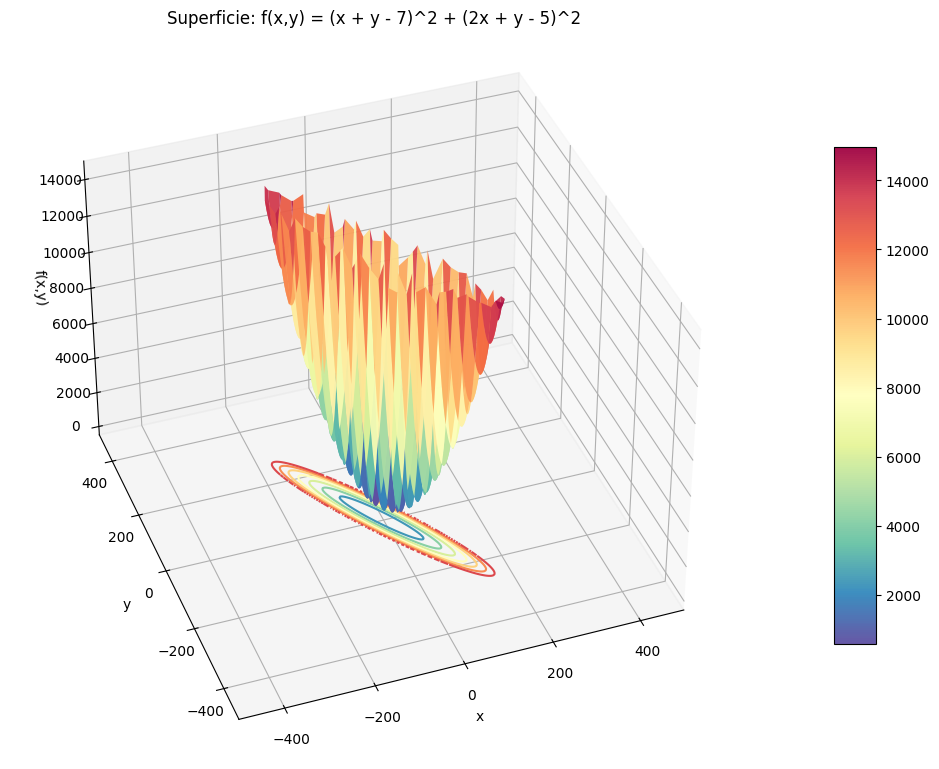

In [9]:
# Graficar superficie 3D de la función
graficar_superficie(
    f,
    xlim=(-500.0, 500.0),
    ylim=(-500.0, 500.0),
    n=300,
    xlabel='x', ylabel='y', zlabel='f(x,y)',
    title='Superficie: f(x,y) = (x + y - 7)^2 + (2x + y - 5)^2',
    cmap='Spectral_r',
    elev=38, azim=-110,
    dist=20,   # vista alejada
    expand=1.0
)

## Trayectoria iterativa hacia el óptimo.

La función dibuja en un mismo gráfico los contornos de una función escalar de dos variables y la ruta (trayectoria) de puntos que normalmente proviene de un algoritmo de optimización.

In [10]:
def graficar_trayectoria(
        puntos: np.ndarray | list[tuple[float, float]],
        f: Callable[[np.ndarray, np.ndarray], np.ndarray],
        xlim: tuple[float, float] = (-5.0, 10.0),
        ylim: tuple[float, float] = (-5.0, 10.0),
        n: int = 100,
        levels: int | list[float] = 30,
        xlabel: str = 'x', ylabel: str = 'y', title: str = 'Trayectoria sobre contornos',
        cmap: str = 'viridis',
    color_trayectoria: str = 'tab:blue',
    mostrar_linea: bool = True,
    color_pasos: Optional[str] = None,
    marcador_pasos: str = '.',
    tam_puntos: int = 44,
    alpha_puntos: float = 0.95,
        marcador_inicio: str = 'o',
        marcador_fin: str = 'X',
        tam_inicio: int = 90,
        tam_fin: int = 120,
        mostrar_etiquetas_nivel: bool = False
    ) -> None:
    """
    Grafica los contornos de z = f(x, y) en el plano XY y superpone la trayectoria
    definida por un conjunto de puntos conectados por una línea.

    Parámetros
    ----------
    puntos: array-like de forma (m, 2)
        Secuencia de puntos (x, y) que definen la trayectoria a dibujar.
    f: Callable[[ndarray, ndarray], ndarray]
        Función escalar de dos variables para generar el mapa de contornos.
    xlim, ylim: (min, max)
        Límites de los ejes X e Y para construir la malla de contorno.
    n: int
        Resolución de la malla (n x n).
    levels: int o lista de float
        Niveles de contorno a dibujar (como en matplotlib.contour).
    xlabel, ylabel, title: str
        Etiquetas y título del gráfico.
    cmap: str
        Colormap para los contornos.
    color_trayectoria: str
        Color de la línea que conecta los puntos (si mostrar_linea=True).
    mostrar_linea: bool
        Si True dibuja una línea que conecta los puntos en orden.
    color_pasos: Optional[str]
        Color de los puntos individuales (pasos) de la trayectoria. Si es None,
        se usará un color más oscuro derivado de 'color_trayectoria'.
    marcador_pasos: str
        Marcador para cada punto de la trayectoria (pasos intermedios).
    tam_puntos: int
        Tamaño de los puntos de la trayectoria (por defecto más grande para mejor visibilidad).
    alpha_puntos: float
        Transparencia (alpha) de los puntos de la trayectoria.
    marcador_inicio, marcador_fin: str
        Marcadores para el punto inicial y el punto final, respectivamente.
    tam_inicio, tam_fin: int
        Tamaños de los marcadores de inicio y fin.
    mostrar_etiquetas_nivel: bool
        Si True, añade etiquetas numéricas a las curvas de nivel.
    """

    # Convertir y validar puntos
    P = np.asarray(puntos, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("'puntos' debe ser de forma (m, 2)")
    if P.shape[0] == 0:
        raise ValueError("'puntos' no puede estar vacío")

    # Malla del plano XY
    x = np.linspace(*xlim, int(n))
    y = np.linspace(*ylim, int(n))
    X, Y = np.meshgrid(x, y)
    Z = np.asarray(f(X, Y), dtype=float)

    # Figura 2D con contornos
    fig, ax = plt.subplots(figsize=(9, 7))
    cs = ax.contour(X, Y, Z, levels=levels, cmap=cmap)
    if mostrar_etiquetas_nivel:
        ax.clabel(cs, inline=True, fontsize=9, fmt='%g')

    # Dibuja línea completa si se solicita
    if mostrar_linea:
        ax.plot(P[:, 0], P[:, 1], color=color_trayectoria, linewidth=2.0, alpha=0.65, label='Trayectoria')

    # Dibuja pequeños puntos para cada paso
    if color_pasos is None:
        # Derivar un color más oscuro a partir del color de la trayectoria
        try:
            base_rgb = np.array(mcolors.to_rgb(color_trayectoria))
            factor = 0.6  # <1.0 oscurece
            darker_rgb = tuple(np.clip(base_rgb * factor, 0.0, 1.0))
            color_pasos_eff = darker_rgb
        except Exception:
            color_pasos_eff = color_trayectoria
    else:
        color_pasos_eff = color_pasos

    ax.scatter(P[:, 0], P[:, 1], s=tam_puntos, c=[color_pasos_eff], marker=marcador_pasos, alpha=alpha_puntos, edgecolors='none', label='Pasos')

    # Punto inicial y final con símbolos únicos
    ax.scatter(P[0, 0], P[0, 1], s=tam_inicio, c='tab:green', marker=marcador_inicio, edgecolors='k', linewidths=0.6, label='Inicio')
    ax.scatter(P[-1, 0], P[-1, 1], s=tam_fin, c='tab:red', marker=marcador_fin, edgecolors='k', linewidths=0.6, label='Fin')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.25)
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

### Descripción:

1. Conversión y validación de entrada: Convierte `puntos` a un arreglo NumPy `P` y comprueba que tenga forma `(m, 2)` y que no esté vacío. Si falla, lanza `ValueError`.
2. Construcción de la malla: Genera vectores `x` e `y` igualmente espaciados dentro de `xlim` y `ylim` con resolución `n`. Con `np.meshgrid` crea las matrices `X`, `Y` y evalúa la función `f` sobre cada par para obtener `Z`.
3. Creación de la figura: Abre una figura y eje 2D (`fig, ax = plt.subplots`) con tamaño fijo para mantener legibilidad.
4. Curvas de nivel: Dibuja los contornos con `ax.contour` usando `levels` y `cmap`. Si `mostrar_etiquetas_nivel=True`, añade etiquetas numéricas sobre algunas curvas.
5. Línea de la trayectoria (opcional): Si `mostrar_linea` es `True`, traza una línea continua que conecta los puntos en el orden dado, con color `color_trayectoria` y transparencia suave.
6. Color de los pasos: Determina el color de los puntos individuales. Si no se especifica `color_pasos`, oscurece el color base de la trayectoria para diferenciar línea y puntos; maneja posibles excepciones devolviendo el color original.
7. Dibujo de los pasos: Coloca un punto por cada fila de `P` con `ax.scatter`, usando tamaño `tam_puntos`, marcador `marcador_pasos` y transparencia `alpha_puntos`.
8. Marcadores inicio y fin: Destaca el primer punto en verde (`Inicio`) y el último en rojo (`Fin`) con marcadores y tamaños distintos (`marcador_inicio`, `marcador_fin`, `tam_inicio`, `tam_fin`).
9. Etiquetas y límites: Ajusta etiquetas de ejes (`xlabel`, `ylabel`), límites (`xlim`, `ylim`), y el título `title`. Añade cuadrícula tenue y una leyenda automática para identificar elementos.
10. Ajuste final y renderizado: Llama a `plt.tight_layout()` para reducir solapamientos y finalmente `plt.show()` para mostrar el gráfico en pantalla.

**Resultado:** Un mapa de contornos que contextualiza la trayectoria de búsqueda, permitiendo ver cómo progresa entre niveles de la función objetivo y dónde inicia y termina.

## Visualización de la trayectoria del método de Máximo Descenso

A continuación se muestra la trayectoria del método de máximo descenso como una línea naranja que se mueve desde el punto inicial (marcado con un círculo) hasta el punto mínimo (marcado con un cuadrado).
Los puntos intermedios del recorrido estarán indicados con pequeños marcadores naranjas, mostrando visualmente cómo el algoritmo desciende paso a paso hacia el mínimo.

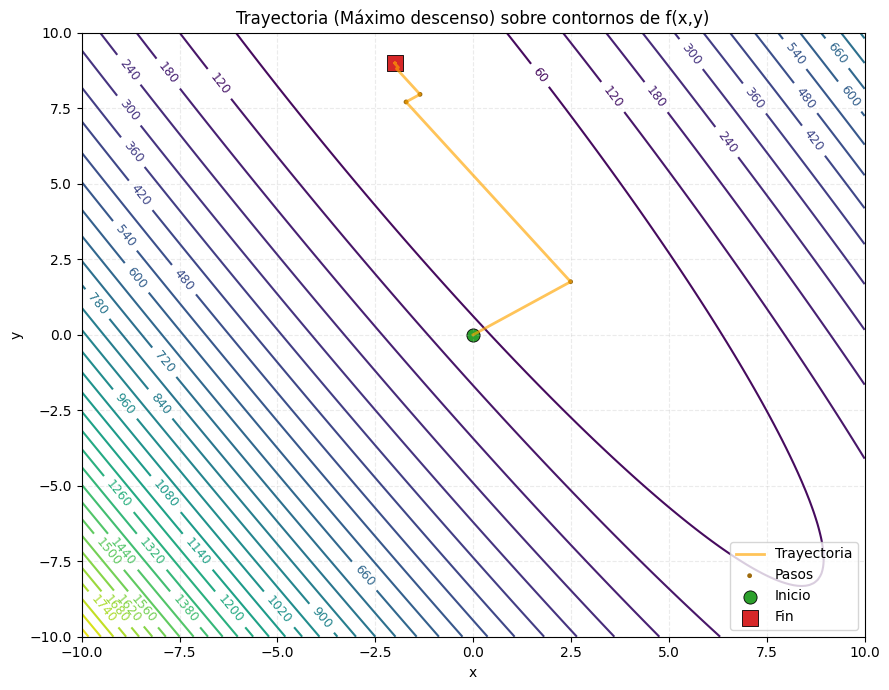

In [11]:
# Trayectoria sobre contornos (Máximo descenso)
puntos_descenso_raw = info.get("ws", info.get("xs"))
puntos_descenso = [tuple(row[:2]) for row in np.asarray(puntos_descenso_raw, dtype=float)]
graficar_trayectoria(
    puntos=puntos_descenso,
    f=f,
    xlim=(x0[0] - 10.0, x0[0] + 10.0),
    ylim=(x0[1] - 10.0, x0[1] + 10.0),
    n=200,
    levels=35,
    xlabel='x', ylabel='y',
    title='Trayectoria (Máximo descenso) sobre contornos de f(x,y)',
    cmap='viridis',
    color_trayectoria='orange',
    mostrar_linea=True,
    marcador_pasos='.',
    tam_puntos=48,
    alpha_puntos=0.95,
    marcador_inicio='o',
    marcador_fin='s',
    mostrar_etiquetas_nivel=True
)

## Visualización de la trayectoria del método de Newton

La trayectoria de Newton se verá como una línea morada muy directa

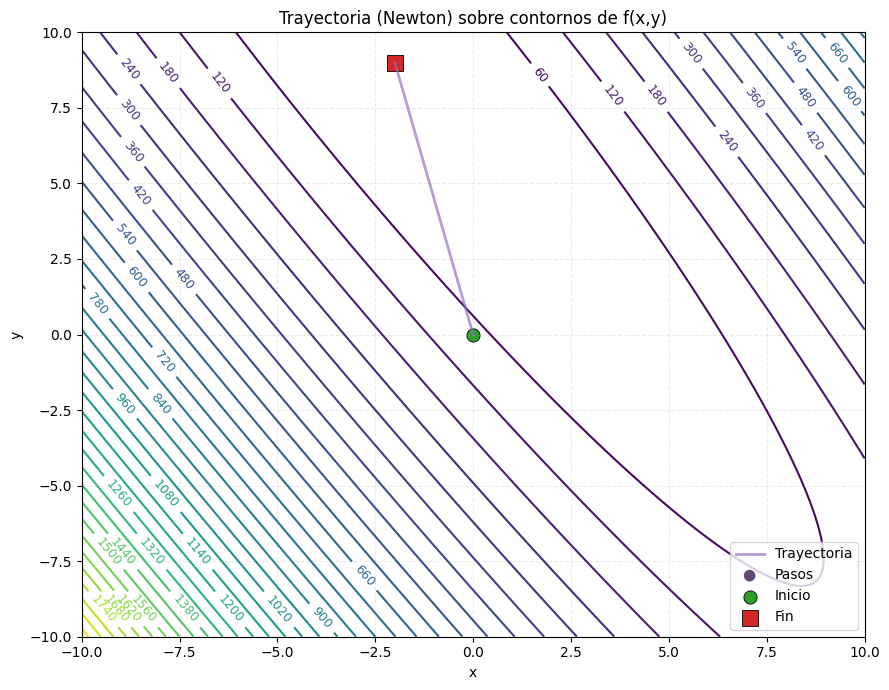

In [12]:
# Graficar trayectoria de Newton sobre los mismos contornos
puntos_newton = [tuple(row[:2]) for row in np.asarray(xs_newton, dtype=float)]
graficar_trayectoria(
    puntos=puntos_newton,
    f=f,
    xlim=(x0[0] - 10.0, x0[0] + 10.0),
    ylim=(x0[1] - 10.0, x0[1] + 10.0),
    n=200,
    levels=35,
    xlabel='x', ylabel='y',
    title='Trayectoria (Newton) sobre contornos de f(x,y)',
    cmap='viridis',
    color_trayectoria='tab:purple',
    mostrar_linea=True,
    marcador_pasos='o',
    tam_puntos=70,
    alpha_puntos=0.95,
    marcador_inicio='o',
    marcador_fin='s',
    mostrar_etiquetas_nivel=True
)